Objective of this notebooks
* KAN learning ODE 
    * Define a HH model in torch(target neurODE)
    * Learn this ODE vector field from data using KAN 
    * See if it could rediscover ODE from scratch. 

In [10]:
import torch
import torch.nn as nn

class HodgkinHuxleyModel(nn.Module):
    def __init__(self):
        super(HodgkinHuxleyModel, self).__init__()
        # Parameters
        self.C_m = 1.0  # membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0  # Nernst reversal potentials, in mV
        self.E_K = -77.0
        self.E_L = -54.387

    def alpha_n(self, V):
        return 0.01 * (V + 55.0) / (1.0 - torch.exp(-0.1 * (V + 55.0)))

    def beta_n(self, V):
        return 0.125 * torch.exp(-0.0125 * (V + 65.0))

    def alpha_m(self, V):
        return 0.1 * (V + 40.0) / (1.0 - torch.exp(-0.1 * (V + 40.0)))

    def beta_m(self, V):
        return 4.0 * torch.exp(-0.0556 * (V + 65.0))

    def alpha_h(self, V):
        return 0.07 * torch.exp(-0.05 * (V + 65.0))

    def beta_h(self, V):
        return 1.0 / (1.0 + torch.exp(-0.1 * (V + 35.0)))

    def forward(self, x, I_ext=0):
        V, m, h, n = x[:, 0], x[:, 1], x[:, 2], x[:, 3]

        # Gating variable updates
        dm = self.alpha_m(V) * (1.0 - m) - self.beta_m(V) * m
        dh = self.alpha_h(V) * (1.0 - h) - self.beta_h(V) * h
        dn = self.alpha_n(V) * (1.0 - n) - self.beta_n(V) * n

        # Ionic currents
        I_Na = self.g_Na * (m ** 3) * h * (V - self.E_Na)
        I_K = self.g_K * (n ** 4) * (V - self.E_K)
        I_L = self.g_L * (V - self.E_L)
        # Membrane potential update
        dV = (I_ext - I_Na - I_K - I_L) / self.C_m
        return torch.stack((dV, dm, dh, dn,), dim=1)
    

# Example usage
if __name__ == "__main__":
    model = HodgkinHuxleyModel()

    # Initial values
    batch_size = 1
    V = torch.tensor([-65.0], requires_grad=True)  # membrane potential
    m = torch.tensor([0.05], requires_grad=True)   # gating variable m
    h = torch.tensor([0.6], requires_grad=True)    # gating variable h
    n = torch.tensor([0.32], requires_grad=True)   # gating variable n
    I_ext = torch.tensor([10.0], requires_grad=True)  # external current
    

    x = torch.cat((V.expand(batch_size, 1),
                    m.expand(batch_size, 1),
                    h.expand(batch_size, 1),
                    n.expand(batch_size, 1),), dim=1)
    I_ext_vec = I_ext.expand(batch_size, )

    # Forward pass
    dx = model(x, I_ext_vec)

    # Backward pass (to compute gradients)
    dx[:, 0].sum().backward()  # Example to compute gradient of dV sum

    print(f"dV: {dx[:, 0]}")
    print(f"Gradient of V: {V.grad}")
    print(f"Gradient of m: {m.grad}")
    print(f"Gradient of h: {h.grad}")
    print(f"Gradient of n: {n.grad}")
    print(f"Gradient of I_ext: {I_ext.grad}")

dV: tensor([9.6891], grad_fn=<SelectBackward0>)
Gradient of V: tensor([-0.6865])
Gradient of m: tensor([62.1000])
Gradient of h: tensor([1.7250])
Gradient of n: tensor([-56.6231])
Gradient of I_ext: tensor([1.])


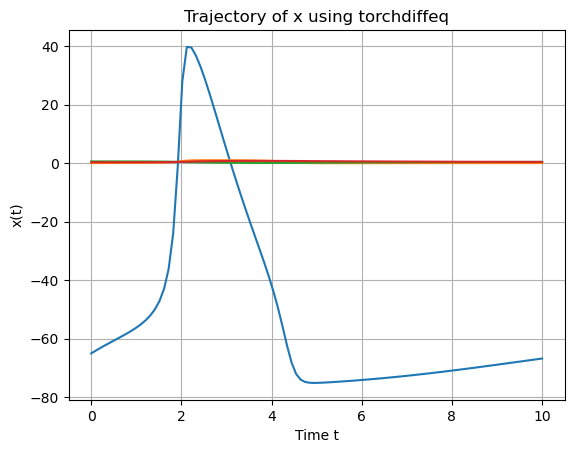

In [20]:
# Step 1: Ensure torchdiffeq is installed. You can install it using:
# pip install torchdiffeq

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt


# Step 3: Initial Conditions
x0 = torch.tensor([[-65.0],
                [0.05],
                [0.6],
                [0.32],], 
                  requires_grad=True).T  # Initial value of x at t=0

# Time points to solve the ODE at
t = torch.linspace(0, 10, steps=100)  # From t=0 to t=5

HHmodel = HodgkinHuxleyModel()
# Step 4: Solve the ODE
# ode_func = ODEFunc()÷
solution = odeint(lambda t,x: HHmodel(x, 10), x0, t, method='dopri5')

# Step 5: Plot the Solution
plt.plot(t.numpy(), solution.detach().numpy()[:,0])
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Trajectory of x using torchdiffeq')
plt.grid(True)
plt.show()

### Original KAN

In [87]:
# collect a dataset of inputs and outputs
from kan import *
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
# f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
HHmodel = HodgkinHuxleyModel()
dataset = create_dataset(lambda x: HHmodel.forward(x,10), n_var=4, 
                         ranges=[[-100,50],[0,1],[0,1],[0,1]],
                         train_num=5000, 
                        test_num=1000,
                        normalize_input=True,
                        normalize_label=True,)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([5000, 4]), torch.Size([5000, 4]))

In [50]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
KANmodel = KAN(width=[4,5,5,4], grid=10, k=3, seed=0, device="cpu")

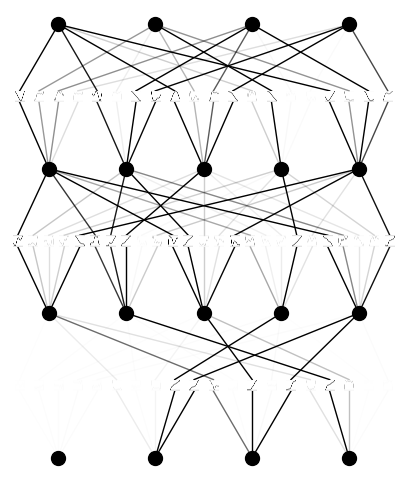

In [46]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [54]:
model.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cpu", lr=1., );#lamb=0.01, lamb_entropy=10., 

train loss: 1.01e-01 | test loss: 1.79e-01 | reg: 4.02e+01 : 100%|█| 100/100 [02:15<00:00,  1.36s/it


In [ ]:
model.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cpu", lr=0.1, );#lamb=0.01, lamb_entropy=10., 

In [56]:
model.train(dataset, opt="LBFGS", lamb=0.0, steps=100, device="cpu", lr=0.1, );#lamb=0.01, lamb_entropy=10., 

train loss: 1.18e-01 | test loss: 1.80e-01 | reg: 4.02e+01 : 100%|█| 100/100 [02:28<00:00,  1.49s/it


In [88]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
KANmodel = KAN(width=[4,8,8,8,4], grid=10, k=3, seed=0, device="cuda")

In [90]:
loss_curve = KANmodel.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10., 

train loss: 8.97e-03 | test loss: 9.47e-03 | reg: 3.83e+01 : 100%|█| 100/100 [04:48<00:00,  2.89s/it


{'train_loss': [array(0.56752443, dtype=float32),
  array(0.2472758, dtype=float32),
  array(0.1256861, dtype=float32),
  array(0.08113312, dtype=float32),
  array(0.0623554, dtype=float32),
  array(0.04879193, dtype=float32),
  array(0.03900607, dtype=float32),
  array(0.03312636, dtype=float32),
  array(0.02852236, dtype=float32),
  array(0.0251775, dtype=float32),
  array(0.02287068, dtype=float32),
  array(0.02079955, dtype=float32),
  array(0.01911013, dtype=float32),
  array(0.01775662, dtype=float32),
  array(0.01648423, dtype=float32),
  array(0.01550263, dtype=float32),
  array(0.01478798, dtype=float32),
  array(0.01413818, dtype=float32),
  array(0.0136897, dtype=float32),
  array(0.01359098, dtype=float32),
  array(0.01368734, dtype=float32),
  array(0.01302751, dtype=float32),
  array(0.01269243, dtype=float32),
  array(0.01246621, dtype=float32),
  array(0.01266478, dtype=float32),
  array(0.01255015, dtype=float32),
  array(0.01216186, dtype=float32),
  array(0.01202204,

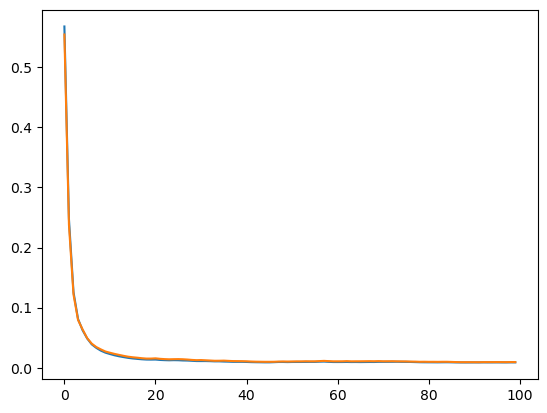

In [95]:
list(loss_curve)
plt.figure()
plt.plot(loss_curve['train_loss'], label='train')
plt.plot(loss_curve['test_loss'], label='test')
# plt.plot(loss_curve['reg'], label='entropy')


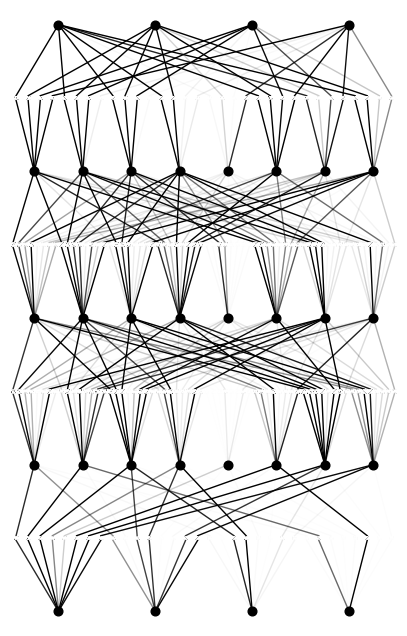

In [96]:
KANmodel.plot(beta=100)

In [99]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sqrt, r2=0.9659944176673889
fixing (0,0,1) with exp, r2=0.9978448152542114
fixing (0,0,2) with x^3, r2=0.9916560053825378
fixing (0,0,3) with sin, r2=0.9951386451721191
fixing (0,0,4) with x^3, r2=0.9975629448890686
fixing (0,1,0) with x^4, r2=0.6822523474693298
fixing (0,1,1) with x^3, r2=0.8611716032028198
fixing (0,1,2) with tanh, r2=0.9975546002388
fixing (0,1,3) with log, r2=0.9982117414474487
fixing (0,1,4) with tanh, r2=0.9979870319366455
fixing (0,2,0) with x^3, r2=0.7829173803329468
fixing (0,2,1) with x^3, r2=0.7813544869422913
fixing (0,2,2) with abs, r2=0.5042372345924377
fixing (0,2,3) with sin, r2=0.5146787762641907
fixing (0,2,4) with tanh, r2=0.962537407875061
fixing (0,3,0) with tanh, r2=0.9829567670822144
fixing (0,3,1) with exp, r2=0.9897459745407104
fixing (0,3,2) with x^4, r2=0.4202316999435425
fixing (0,3,3) with tanh, r2=0.6258811354637146
fixing (0,3,4) with tanh, r2=0.6311210989952087
fixing (1,0,0) with x^4, r2=0.3383375406265259
fixing (1,

In [115]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
KANmodel2 = KAN(width=[4,6,6,4], grid=8, k=3, seed=0, device="cuda")

In [116]:
loss_curve = KANmodel2.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10., 

train loss: 1.25e-02 | test loss: 1.36e-02 | reg: 2.84e+01 : 100%|█| 100/100 [02:15<00:00,  1.36s/it


In [117]:
loss_curve = KANmodel2.train(dataset, opt="LBFGS", lamb=5e-5, lamb_entropy=0.1, steps=100, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10., 
# model.train(dataset, opt="LBFGS", steps=50, lamb=5e-5, lamb_entropy=2.);

train loss: 7.85e-03 | test loss: 9.84e-03 | reg: 9.60e+00 : 100%|█| 100/100 [02:17<00:00,  1.38s/it


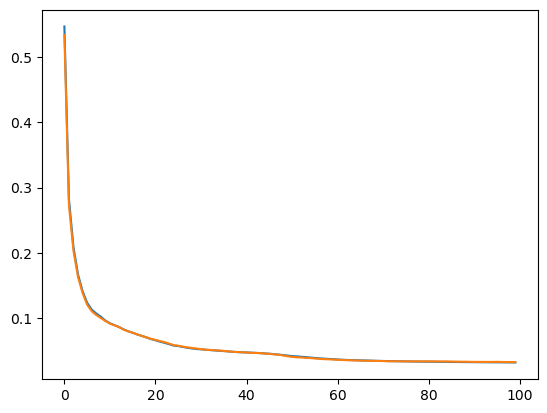

In [104]:
plt.figure()
plt.plot(loss_curve['train_loss'], label='train')
plt.plot(loss_curve['test_loss'], label='test')
# plt.plot(loss_curve['reg'], label='entropy')


In [106]:
loss_curve = KANmodel2.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10., 

train loss: 2.92e-02 | test loss: 3.17e-02 | reg: 2.49e+01 : 100%|█| 100/100 [01:33<00:00,  1.07it/s


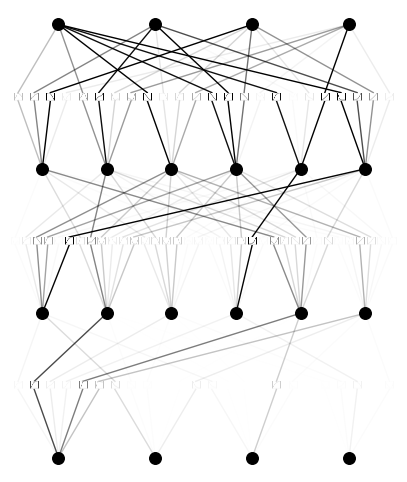

In [119]:
KANmodel2.plot(beta=5)

In [120]:
KANmodel2.save_ckpt("HHmodel2.ckpt")

save this model to ./model_ckpt/HHmodel2.ckpt


In [135]:
KANmodel2.load_ckpt("HHmodel2.ckpt")

In [136]:
KANmodel2_prune = KANmodel2.prune(threshold=3e-2)


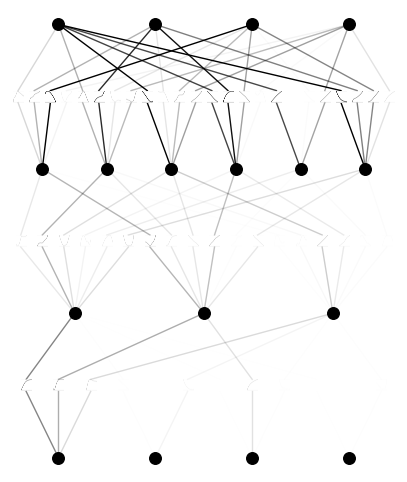

In [132]:
KANmodel2_prune = KANmodel2.prune(threshold=3e-2)
KANmodel2_prune(dataset['train_input'].cuda())
KANmodel2_prune.plot()

In [133]:
lib = ['x','x^2','x^3','x^4','exp','tanh','sin','abs', ]#'log','sqrt',
KANmodel2_prune.auto_symbolic(lib=lib)

fixing (0,0,0) with tanh, r2=0.9993529915809631
fixing (0,0,1) with tanh, r2=0.9962966442108154
fixing (0,0,2) with tanh, r2=0.9344719052314758
fixing (0,1,0) with sqrt, r2=0.9992910623550415
fixing (0,1,1) with x^2, r2=0.9715674519538879
fixing (0,1,2) with x^4, r2=0.9995607733726501
fixing (0,2,0) with exp, r2=0.9985772967338562
fixing (0,2,1) with log, r2=0.9999550580978394
fixing (0,2,2) with exp, r2=0.9982404708862305
fixing (0,3,0) with x^2, r2=0.8986075520515442
fixing (0,3,1) with sin, r2=0.9953294396400452
fixing (0,3,2) with sin, r2=0.880283534526825
fixing (1,0,0) with tanh, r2=0.9898565411567688
fixing (1,0,1) with log, r2=0.9871894121170044
fixing (1,0,2) with sin, r2=0.9937015175819397
fixing (1,0,3) with sin, r2=0.9065206050872803
fixing (1,0,4) with sin, r2=0.9534234404563904
fixing (1,0,5) with x^4, r2=0.979297399520874
fixing (1,1,0) with x^2, r2=0.989141583442688
fixing (1,1,1) with tanh, r2=0.9978712797164917
fixing (1,1,2) with sqrt, r2=0.9970290064811707
fixing (1

In [134]:
KANmodel2_prune.train(dataset, opt="LBFGS", lamb=0.0001, steps=100, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10.,

train loss: nan | test loss: nan | reg: nan :   5%|▊                | 5/100 [00:06<02:00,  1.26s/it]


KeyboardInterrupt: 

In [ ]:
KANmodel2.prune(0.1)

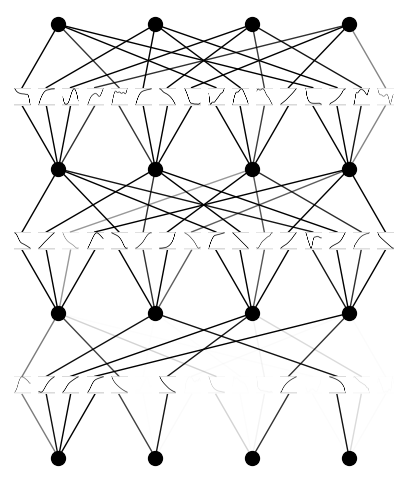

In [107]:
KANmodel2.plot(beta=3)

In [108]:
# automatic mode
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
KANmodel2.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9565247297286987
fixing (0,0,1) with sin, r2=0.9960405826568604
fixing (0,0,2) with tanh, r2=0.9979204535484314
fixing (0,0,3) with tanh, r2=0.9977939128875732
fixing (0,1,0) with log, r2=0.999804675579071
fixing (0,1,1) with sin, r2=0.9487070441246033
fixing (0,1,2) with exp, r2=0.9995918869972229
fixing (0,1,3) with tanh, r2=0.6636586785316467
fixing (0,2,0) with exp, r2=0.9989569187164307
fixing (0,2,1) with log, r2=0.9325060844421387
fixing (0,2,2) with exp, r2=0.9527693390846252
fixing (0,2,3) with log, r2=0.9992629885673523
fixing (0,3,0) with x^4, r2=0.8784766793251038
fixing (0,3,1) with log, r2=0.9998867511749268
fixing (0,3,2) with sqrt, r2=0.9885644912719727
fixing (0,3,3) with sin, r2=0.8803389668464661
fixing (1,0,0) with tanh, r2=0.9842340350151062
fixing (1,0,1) with sqrt, r2=0.9998290538787842
fixing (1,0,2) with sqrt, r2=0.9936516284942627
fixing (1,0,3) with sin, r2=0.9897693991661072
fixing (1,1,0) with tanh, r2=0.9970333576202393
fixing

In [110]:
KANmodel2.unfix_symbolic_all()

In [111]:
KANmodel2.train(dataset, opt="LBFGS", lamb=0.0001, steps=10, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10.,

train loss: nan | test loss: nan | reg: nan :  30%|█████▍            | 3/10 [00:03<00:08,  1.22s/it]


KeyboardInterrupt: 

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sqrt, r2=0.9659944176673889
fixing (0,0,1) with exp, r2=0.9978448152542114
fixing (0,0,2) with x^3, r2=0.9916560053825378
fixing (0,0,3) with sin, r2=0.9951386451721191
fixing (0,0,4) with x^3, r2=0.9975629448890686
fixing (0,1,0) with x^4, r2=0.6822523474693298
fixing (0,1,1) with x^3, r2=0.8611716032028198
fixing (0,1,2) with tanh, r2=0.9975546002388
fixing (0,1,3) with log, r2=0.9982117414474487
fixing (0,1,4) with tanh, r2=0.9979870319366455
fixing (0,2,0) with x^3, r2=0.7829173803329468
fixing (0,2,1) with x^3, r2=0.7813544869422913
fixing (0,2,2) with abs, r2=0.5042372345924377
fixing (0,2,3) with sin, r2=0.5146787762641907
fixing (0,2,4) with tanh, r2=0.962537407875061
fixing (0,3,0) with tanh, r2=0.9829567670822144
fixing (0,3,1) with exp, r2=0.9897459745407104
fixing (0,3,2) with x^4, r2=0.4202316999435425
fixing (0,3,3) with tanh, r2=0.6258811354637146
fixing (0,3,4) with tanh, r2=0.6311210989952087
fixing (1,0,0) with x^4, r2=0.3383375406265259
fixing (1,

In [ ]:
KANmodel.prune(0.1)

KAN(
  (biases): ModuleList(
    (0-2): 3 x Linear(in_features=8, out_features=1, bias=False)
    (3): Linear(in_features=4, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)

In [97]:
KANmodel.prune(0.1)

KAN(
  (biases): ModuleList(
    (0-2): 3 x Linear(in_features=8, out_features=1, bias=False)
    (3): Linear(in_features=4, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)

In [98]:
loss_curve2 = KANmodel.train(dataset, opt="LBFGS", lamb=0.0001, steps=20, device="cuda", lr=1., )#lamb=0.01, lamb_entropy=10., 

train loss: nan | test loss: nan | reg: nan :  20%|███▌              | 4/20 [00:14<00:59,  3.73s/it]


KeyboardInterrupt: 

### Efficient KAN


### FastKAN

In [59]:
from fastkan import *
import torch.nn.functional as F

In [77]:
# collect a dataset of inputs and outputs
from kan import *
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
# f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
HHmodel = HodgkinHuxleyModel()
dataset = create_dataset(lambda x: HHmodel.forward(x,10), n_var=4, 
                         ranges=[[-100,50],[0,1],[0,1],[0,1]],
                         train_num=10000, 
                        test_num=1000,
                        normalize_input=True,
                        normalize_label=True,)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([10000, 4]), torch.Size([10000, 4]))

In [78]:
fastkan_model = FastKAN(layers_hidden=[4, 5, 5, 4],
        grid_min=-2.,
        grid_max=2.,
        num_grids=32,
        use_base_update=True,
        base_activation=F.silu,
        spline_weight_init_scale= 0.1,)

In [81]:
# move all data to GPU
for key in dataset.keys():
    dataset[key] = dataset[key].to("cuda")

loss_fn = nn.MSELoss()
fastkan_model = fastkan_model.to("cuda")
optimizer = torch.optim.Adam(fastkan_model.parameters(), lr=0.01, weight_decay=1e-3)
# optimizer = torch.optim.LBFGS(fastkan_model.parameters(), lr=0.01)
pbar = tqdm(range(10000))
for steps in pbar:
    optimizer.zero_grad()
    loss = loss_fn(fastkan_model(dataset["train_input"]), dataset["train_label"])
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_loss = loss_fn(fastkan_model(dataset["test_input"]), dataset["test_label"])
    pbar.set_description(f"Loss: {loss.item():.3e} Val Loss: {val_loss.item():.3e}")
    # if steps % 50 == 0:
    #     print(f"Step: {steps}, Loss: {loss.item()} Val Loss: {val_loss.item()}")
    


Loss: 4.877e-02 Val Loss: 9.849e-02: 100%|██████████| 10000/10000 [00:38<00:00, 256.50it/s]


In [83]:
fastkan_model = FastKAN(layers_hidden=[4, 8, 8, 8, 4],
        grid_min=-2.,
        grid_max=2.,
        num_grids=32,
        use_base_update=True,
        base_activation=F.silu,
        spline_weight_init_scale= 0.1,)

# move all data to GPU
for key in dataset.keys():
    dataset[key] = dataset[key].to("cuda")

loss_fn = nn.MSELoss()
fastkan_model = fastkan_model.to("cuda")
optimizer = torch.optim.Adam(fastkan_model.parameters(), lr=0.01, weight_decay=1e-3)
# optimizer = torch.optim.LBFGS(fastkan_model.parameters(), lr=0.01)
pbar = tqdm(range(50000))
for steps in pbar:
    optimizer.zero_grad()
    loss = loss_fn(fastkan_model(dataset["train_input"]), dataset["train_label"])
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_loss = loss_fn(fastkan_model(dataset["test_input"]), dataset["test_label"])
    pbar.set_description(f"Train Loss: {loss.item():.3e} Test Loss: {val_loss.item():.3e}")
    # if steps % 50 == 0:
    #     print(f"Step: {steps}, Loss: {loss.item()} Val Loss: {val_loss.item()}")
    


Loss: 8.890e-01 Val Loss: 9.034e-01:   0%|          | 0/50000 [00:00<?, ?it/s]

Loss: 3.599e-02 Val Loss: 7.757e-02: 100%|██████████| 50000/50000 [03:55<00:00, 212.65it/s]


In [86]:
fastkan_model = FastKAN(layers_hidden=[4, 8, 8, 8, 4],
        grid_min=-2.,
        grid_max=2.,
        num_grids=32,
        use_base_update=True,
        base_activation=F.silu,
        spline_weight_init_scale= 0.1,)

# move all data to GPU
for key in dataset.keys():
    dataset[key] = dataset[key].to("cuda")

loss_fn = nn.MSELoss()
fastkan_model = fastkan_model.to("cuda")
# optimizer = torch.optim.Adam(fastkan_model.parameters(), lr=0.01, weight_decay=1e-3)
optimizer = torch.optim.AdamW(fastkan_model.parameters(), lr=1e-2, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
pbar = tqdm(range(50000))
for steps in pbar:
    optimizer.zero_grad()
    loss = loss_fn(fastkan_model(dataset["train_input"]), dataset["train_label"])
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_loss = loss_fn(fastkan_model(dataset["test_input"]), dataset["test_label"])
    pbar.set_description(f"Train Loss: {loss.item():.3e} Test Loss: {val_loss.item():.3e} lr: {scheduler.get_last_lr()[0]:.2e}")
    scheduler.step()
    # if steps % 50 == 0:
    #     print(f"Step: {steps}, Loss: {loss.item()} Val Loss: {val_loss.item()}")
    


Train Loss: 2.936e-02 Test Loss: 2.410e-01 lr: 6.74e-05: 100%|██████████| 50000/50000 [03:12<00:00, 259.15it/s]
